# Neural Rubik's cube solver

### Rubik's cube definition as a 3-D tensor

In [1]:
import torch
import numpy as np
def init_cube():
    cube = torch.zeros((5, 5, 5))
    cube[1:4, 1:4, 4] = 1  # Right face
    cube[1:4, 1:4, 0] = 2  # Left face
    cube[0, 1:4, 1:4] = 3  # Up face
    cube[4, 1:4, 1:4] = 4  # Down face
    cube[1:4, 4, 1:4] = 5  # Front face
    cube[1:4, 0, 1:4] = 6  # Back face
    return cube

# represent the solved cube as a 3-D tensor
RUBIKS_CUBE = init_cube()
# scramble the cube up to this many moves
MAX_MOVES = 10
# make this many passes over the dataset
NUM_EPOCHS = 100
# Learning rate for Gradient Descent
LEARNING_RATE = 0.001

### Scrambling

In [2]:
import random

move_types = ["R", "RP", "L", "LP", "U", "UP", "D", "DP", "F", "FP", "B", "BP"]

def move(cube, move_type):
    cube = cube.squeeze()
    cube = cube.clone()
    
    if move_type == "U":
        cube[0:2] = torch.rot90(cube[0:2], 1, (2, 1))
    elif move_type == "UP":
        cube[0:2] = torch.rot90(cube[0:2], -1, (2, 1))
    elif move_type == "D":
        cube[3:5] = torch.rot90(cube[3:5], 1, (2, 1))
    elif move_type == "DP":
        cube[3:5] = torch.rot90(cube[3:5], -1, (2, 1))
    elif move_type == "L":
        cube[:,:, 0:2] = torch.rot90(cube[:, :, 0:2], 1, (1, 0))
    elif move_type == "LP":
        cube[:,:, 0:2] = torch.rot90(cube[:, :, 0:2], -1, (1, 0))
    elif move_type == "R":
        cube[:,:, 3:5] = torch.rot90(cube[:,:, 3:5], -1, (1, 0))
    elif move_type == "RP":
        cube[:,:, 3:5] = torch.rot90(cube[:,:, 3:5], 1, (1, 0))
    elif move_type == "F":
        cube[:, 3:5] = torch.rot90(cube[:, 3:5], 1, (2, 0))
    elif move_type == "FP":
        cube[:, 3:5] = torch.rot90(cube[:, 3:5], -1, (2, 0))
    elif move_type == "B":
        cube[:, 0:2] = torch.rot90(cube[:, 0:2], -1, (2, 0))
    elif move_type == "BP":
        cube[:, 0:2] = torch.rot90(cube[:, 0:2], 1, (2, 0))
    return cube
        
def apply_moves(cube, moves):
    for m in moves:
        cube = move(cube, m)
    return cube

def reverse_moves(moves):
    # Turn clockwise moves into counter-clockwise and vice versa
    # Also reverse the order of moves
    result = []
    for m in moves:
      result.append(reverse_move(m))
    return list(reversed(result))

def reverse_move(m):
    # Turn clockwise moves into counter-clockwise and vice versa
    if m.endswith("P"):
      return  m[0]
    return m + "P"


## Data Loader


In [3]:
from torch.utils.data import Dataset, DataLoader

def generate_data(num_samples):
    data = []
    seen_states = set()
    while len(data) < num_samples:
        moves = random.choices(move_types, k=random.randint(1, MAX_MOVES))
        scrambled_cube = apply_moves(RUBIKS_CUBE.clone(), moves)
        best_move = reverse_move(moves[-1])
        
        cube_list = scrambled_cube.flatten().cpu().tolist()
        cube_tuple = tuple(cube_list)
        # Do not add if we have seen this scramble before
        if cube_tuple not in seen_states:
                seen_states.add(cube_tuple)
                # add the reverse of the last move as the best move
                data.append((scrambled_cube, best_move))

    return data

class RubiksCubeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create separate datasets for training and evaluation
train_set_size = 100000
eval_set_size = 1000
combined_data = generate_data(train_set_size + eval_set_size)
random.shuffle(combined_data)

train_data = combined_data[:train_set_size]
eval_data  = combined_data[train_set_size:]
train_dataset = RubiksCubeDataset(train_data)
eval_dataset = RubiksCubeDataset(eval_data)


# Training & Eval

In [4]:
import matplotlib.pyplot as plt
import time

def train_and_display( net ):
    eval_accuracies = []
    training_loss = []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
      print("Epoch", epoch)
      loss = net.train()
      acc = net.eval()
      eval_accuracies.append(acc)
      training_loss.append(loss)
    end_time = time.time()
    total_time = end_time - start_time

    print("----------------------------------------")
    print(f"Training took {total_time:.2f} seconds.")
    print(f"Peak accuracy {max(eval_accuracies)} %.")
    
    # plot accuracies
    plt.plot(eval_accuracies)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()
    
    #plot loss
    plt.plot(training_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.show()


# 3D Convolution Neural Network

Epoch 0
Training Loss: 2.4346
Percentage of correctly solved cubes: 0.80%
Epoch 1
Training Loss: 2.3570
Percentage of correctly solved cubes: 1.70%
Epoch 2
Training Loss: 2.3241
Percentage of correctly solved cubes: 2.80%
Epoch 3
Training Loss: 2.3079
Percentage of correctly solved cubes: 3.50%
Epoch 4
Training Loss: 2.2950
Percentage of correctly solved cubes: 4.20%
Epoch 5
Training Loss: 2.2821
Percentage of correctly solved cubes: 4.90%
Epoch 6
Training Loss: 2.2682
Percentage of correctly solved cubes: 5.50%
Epoch 7
Training Loss: 2.2528
Percentage of correctly solved cubes: 7.40%
Epoch 8
Training Loss: 2.2352
Percentage of correctly solved cubes: 8.30%
Epoch 9
Training Loss: 2.2150
Percentage of correctly solved cubes: 9.50%
Epoch 10
Training Loss: 2.1922
Percentage of correctly solved cubes: 10.20%
Epoch 11
Training Loss: 2.1669
Percentage of correctly solved cubes: 11.90%
Epoch 12
Training Loss: 2.1394
Percentage of correctly solved cubes: 13.20%
Epoch 13
Training Loss: 2.1105
P

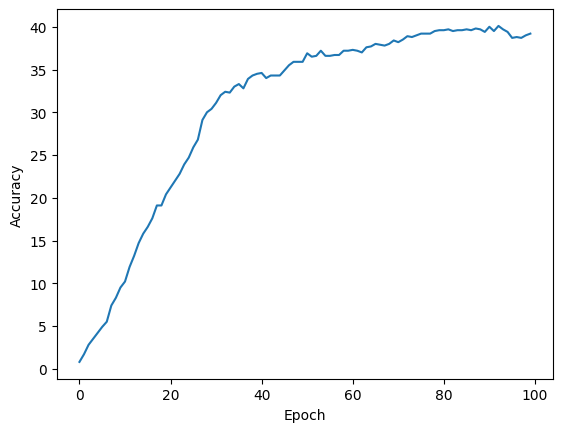

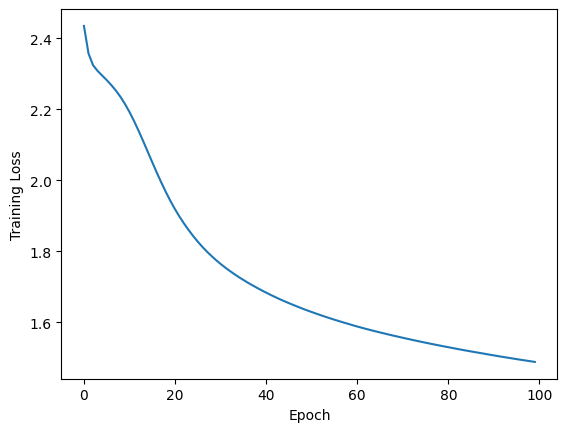

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
class RubiksSolverNetwork(torch.nn.Module):
    def __init__(self, train_dataset, eval_dataset):
        super().__init__()

        # Create data loaders
        self.train_loader = DataLoader(train_dataset, batch_size=32)
        self.eval_loader = DataLoader(eval_dataset, batch_size=1)

        # Define a convolutional layer
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  # 16 output channels
        
        # Define a Linear layer for the flattened convolution output
        self.fc1 = nn.Linear(16 * 5 * 5 * 5, 128)  # 16 channels * 5x5x5 cube size
        self.fc2 = nn.Linear(128, 12)  # 12 output moves

    def train(self):
        losses = []
        for cubes, best_moves in self.train_loader:
            # cubes is of shape 32x5x5x5
            # Convert moves to indices. R -> 0, RP -> 1, L -> 2 and so on.
            best_moves = torch.tensor([move_types.index(m) for m in best_moves])
            # Forward pass
            output = self.forward(cubes)
            # output is of shape 32x12

            # cross-entropy loss
            log_probs = torch.log_softmax(output, dim=1)  # Log probabilities
            # at this point, log_probs is a matrix of shape 32x12
            best_log_probs = log_probs[range(len(best_moves)), best_moves]
            # best_log_probs is a column vector with 32 rows
            loss = -best_log_probs.mean()  # Negative log-likelihood

            # Compute gradients using autograd
            loss.backward()

            # Gradient descent updates
            with torch.no_grad():
                for param in self.parameters():
                    param -= LEARNING_RATE * param.grad
                    param.grad.zero_()

            losses.append(loss.item())
        print(f"Training Loss: {np.mean(losses):.4f}")
        return np.mean(losses)

    def solve(self, cube):
        solved = False
        for _ in range(2 * MAX_MOVES):  # Try up to these many moves
            output = self.forward(cube)
            predicted_move_index = torch.argmax(output, dim=1).item()
            predicted_move = move_types[predicted_move_index]

            # Apply the predicted move to the cube
            cube = move(cube, predicted_move)
            # Check if the cube is solved
            if np.array_equal(cube, RUBIKS_CUBE):
                solved = True
                break

            # add batch dimension to make the shape (1, 5, 5, 5)
            # this is because forward() expects a batch dimension.
            cube.unsqueeze_(0)
        return cube.squeeze(), solved

    def eval(self):
        correct = 0
        total = 0

        for cube, _ in self.eval_loader:  # batch_size=1 ensures cube has shape (1, 5, 5, 5)
            cube, solved = self.solve(cube)
            if solved:
                correct += 1
            total += 1
        accuracy = 100 * correct / total
        print(f"Percentage of correctly solved cubes: {accuracy:.2f}%")
        return accuracy
    
    def forward(self, x):
        # Input shape: (batch_size, 5, 5, 5)
        # Add channel dimension => (batch_size, 1, depth=5, height=5, width=5)
        x = x.unsqueeze(1)
        
        # Pass through convolutional layer
        x = F.relu(self.conv1(x))  # Output shape: (batch_size, 16, 5, 5)
        
        # Flatten the output
        x = x.reshape(x.size(0), -1)  # Output shape: (batch_size, 16 * 5 * 5)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))  # Output shape: (batch_size, 128)
        return self.fc2(x)  # Output shape: (batch_size, 12)


# Instantiate the neural network
net = RubiksSolverNetwork(train_dataset, eval_dataset)
train_and_display(net)


In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def display_cube(cube):
    faces = [cube[0], cube[4], cube[:, 0], cube[:, 4], cube[:, :, 0], cube[:, :, 4]]
    colors = ["black", "red", "orange", "white", "yellow", "green", "blue"]
    cmap = mcolors.ListedColormap(colors)
    titles = ["Up", "Down", "Back", "Front", "Left", "Right"]

    fig, axes = plt.subplots(2, 3, figsize=(8, 6))

    for ax, face, title in zip(axes.flat, faces, titles):
        ax.imshow(face, cmap=cmap, vmin=0, vmax=6)
        ax.set_title(title)
        ax.axis("off")

    plt.show()

# Adding more convolution layers, Vanishing gradient (non ResNet)

Epoch 0
Training Loss: 2.4859
Percentage of correctly solved cubes: 0.00%
Epoch 1
Training Loss: 2.4853
Percentage of correctly solved cubes: 0.00%
Epoch 2
Training Loss: 2.4850
Percentage of correctly solved cubes: 0.00%
Epoch 3
Training Loss: 2.4848
Percentage of correctly solved cubes: 0.00%
Epoch 4
Training Loss: 2.4847
Percentage of correctly solved cubes: 0.00%
Epoch 5
Training Loss: 2.4846
Percentage of correctly solved cubes: 0.00%
Epoch 6
Training Loss: 2.4845
Percentage of correctly solved cubes: 0.00%
Epoch 7
Training Loss: 2.4844
Percentage of correctly solved cubes: 0.00%
Epoch 8
Training Loss: 2.4843
Percentage of correctly solved cubes: 0.00%
Epoch 9
Training Loss: 2.4842
Percentage of correctly solved cubes: 0.00%
Epoch 10
Training Loss: 2.4841
Percentage of correctly solved cubes: 0.00%
Epoch 11
Training Loss: 2.4840
Percentage of correctly solved cubes: 0.00%
Epoch 12
Training Loss: 2.4839
Percentage of correctly solved cubes: 0.00%
Epoch 13
Training Loss: 2.4837
Perc

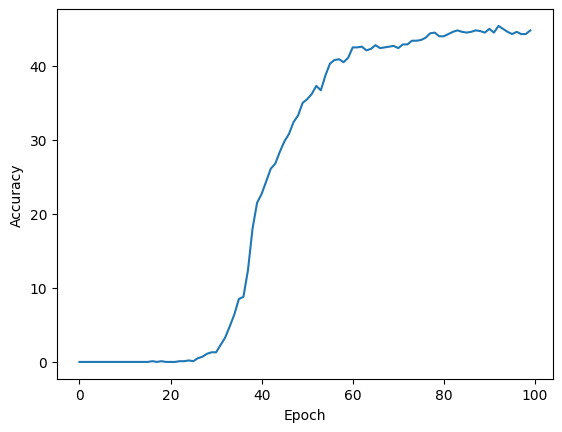

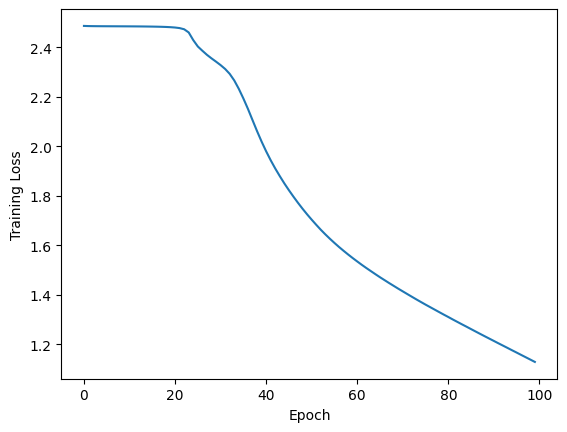

In [7]:
# The number of convolution layers is increased to 5

class RubiksSolverNonResNet(RubiksSolverNetwork):
    def __init__(self, train_dataset, eval_dataset):
        super().__init__(train_dataset, eval_dataset)

        # Define a group-invariant conv layer
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Input shape: (batch_size, 5, 5, 5)
        # Add channel dimension => (batch_size, 1, depth=5, height=5, width=5)
        x = x.unsqueeze(1)
        
        # Pass through convolutional layer
        x = F.relu(self.conv1(x))  # Output shape: (batch_size, 16, 5, 5)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        # Flatten the output
        x = x.reshape(x.size(0), -1)  # Output shape: (batch_size, 16 * 5 * 5)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))  # Output shape: (batch_size, 128)
        return self.fc2(x)  # Output shape: (batch_size, 12)

net = RubiksSolverNonResNet(train_dataset, eval_dataset)
train_and_display(net)



# With Residual Networks (ResNet)

Epoch 0
Training Loss: 2.4301
Percentage of correctly solved cubes: 1.00%
Epoch 1
Training Loss: 2.3456
Percentage of correctly solved cubes: 2.10%
Epoch 2
Training Loss: 2.3105
Percentage of correctly solved cubes: 3.60%
Epoch 3
Training Loss: 2.2867
Percentage of correctly solved cubes: 4.40%
Epoch 4
Training Loss: 2.2630
Percentage of correctly solved cubes: 5.50%
Epoch 5
Training Loss: 2.2364
Percentage of correctly solved cubes: 7.10%
Epoch 6
Training Loss: 2.2048
Percentage of correctly solved cubes: 11.60%
Epoch 7
Training Loss: 2.1670
Percentage of correctly solved cubes: 14.60%
Epoch 8
Training Loss: 2.1228
Percentage of correctly solved cubes: 17.60%
Epoch 9
Training Loss: 2.0741
Percentage of correctly solved cubes: 18.40%
Epoch 10
Training Loss: 2.0241
Percentage of correctly solved cubes: 19.80%
Epoch 11
Training Loss: 1.9765
Percentage of correctly solved cubes: 20.30%
Epoch 12
Training Loss: 1.9328
Percentage of correctly solved cubes: 22.20%
Epoch 13
Training Loss: 1.89

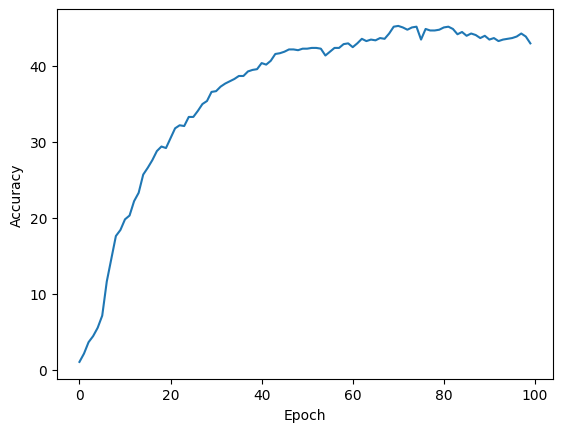

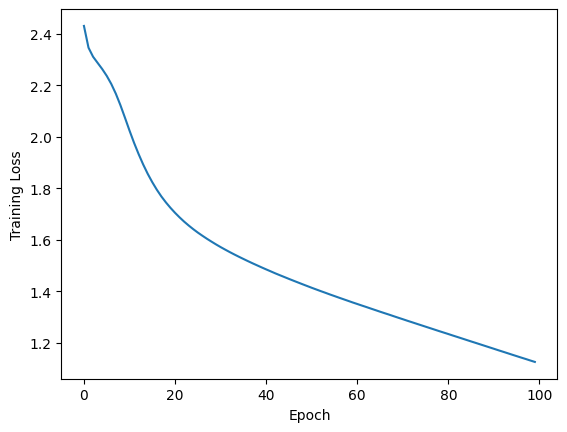

In [8]:
# Incorporate Residual Network to address vanishing gradient and instability issues

class RubiksSolverResNet(RubiksSolverNetwork):
    def __init__(self, train_dataset, eval_dataset):
        super().__init__(train_dataset, eval_dataset)

        # Define a group-invariant conv layer
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Input shape: (batch_size, 5, 5, 5)
        # Add channel dimension => (batch_size, 1, depth=5, height=5, width=5)
        x = x.unsqueeze(1)
        
        # Pass through convolutional layer
        x = F.relu(self.conv1(x))  # Output shape: (batch_size, 16, 5, 5)
        x = x + F.relu(self.conv2(x))
        x = x + F.relu(self.conv3(x))
        x = x + F.relu(self.conv4(x))
        x = x + F.relu(self.conv5(x))
        
        # Flatten the output
        x = x.reshape(x.size(0), -1)  # Output shape: (batch_size, 16 * 5 * 5)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))  # Output shape: (batch_size, 128)
        return self.fc2(x)  # Output shape: (batch_size, 12)

net = RubiksSolverResNet(train_dataset, eval_dataset)
train_and_display(net)
        

# Group Equivariant G-CNN with 6 symmetries

Epoch 0
Training Loss: 2.3764
Percentage of correctly solved cubes: 2.60%
Epoch 1
Training Loss: 2.2905
Percentage of correctly solved cubes: 6.00%
Epoch 2
Training Loss: 2.2257
Percentage of correctly solved cubes: 9.50%
Epoch 3
Training Loss: 2.1474
Percentage of correctly solved cubes: 12.00%
Epoch 4
Training Loss: 2.0674
Percentage of correctly solved cubes: 16.00%
Epoch 5
Training Loss: 1.9986
Percentage of correctly solved cubes: 20.50%
Epoch 6
Training Loss: 1.9432
Percentage of correctly solved cubes: 25.10%
Epoch 7
Training Loss: 1.8978
Percentage of correctly solved cubes: 27.30%
Epoch 8
Training Loss: 1.8591
Percentage of correctly solved cubes: 29.00%
Epoch 9
Training Loss: 1.8248
Percentage of correctly solved cubes: 30.80%
Epoch 10
Training Loss: 1.7947
Percentage of correctly solved cubes: 31.00%
Epoch 11
Training Loss: 1.7682
Percentage of correctly solved cubes: 33.20%
Epoch 12
Training Loss: 1.7454
Percentage of correctly solved cubes: 33.90%
Epoch 13
Training Loss: 1

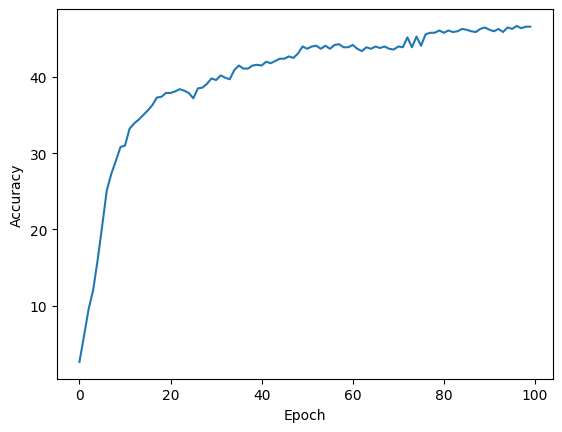

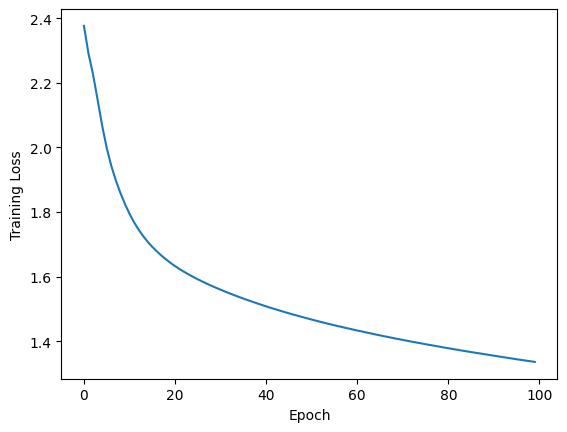

In [9]:
# Choose 6 So(3) symmetries for 6 faces of the cube

# x rotation works on depth and height
# y rotation works on depth and width
rot_dims = {
    
    'x': (2, 3),
    'y': (2, 4),
}

def rotate_3d_kernel(kernel, orientation_idx):
    """
    Produces 6 orientations for kernel (out_ch, in_ch, D, H, W).
    orientation_idx ∈ [0..5] => 6 'face-up' transforms
    """
    # (axis, k) for each of the 6 ways to put a face 'up'
    face_up_options = [
        (None, 0),   # identity
        ('x', 1),
        ('x', 2),
        ('x', 3),
        ('y', 1),
        ('y', 3),
    ]
    if orientation_idx == 0:
        return kernel
        
    axis, k = face_up_options[orientation_idx]
    return torch.rot90(kernel, k=k, dims=rot_dims[axis])


class GroupConv3D(nn.Module):
    def __init__(self, in_channels, out_channels, num_orientations=6):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_orientations = num_orientations

        # Base kernel: shape (out_channels, in_channels, D, H, W)
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, 3, 3, 3) * 0.1)

    def forward(self, x):
        # x shape: (batch_size, in_channels, D, H, W)

        conv_outputs = []
        for orientation in range(self.num_orientations):
            # 1) Rotate the base kernel
            w = rotate_3d_kernel(self.weight, orientation)

            # 2) Standard 3D convolution with rotated kernel
            output = F.conv3d(x, w, stride=1, padding=1)
            conv_outputs.append(output)

        # 3) Sum (or average) across all oriented conv results
        # shape of each conv_g: (batch_size, out_channels, D_out, H_out, W_out)
        stacked = torch.stack(conv_outputs, dim=0)  # (num_orientations, batch, out_ch, D_out, H_out, W_out)
        return stacked.sum(dim=0)  # (batch, out_channels, D_out, H_out, W_out)



class RubiksSolverGCNN(RubiksSolverNetwork):
    def __init__(self, train_dataset, eval_dataset):
        super().__init__(train_dataset, eval_dataset)

        # Define a group-invariant conv layer
        self.conv1 = GroupConv3D(in_channels=1, out_channels=16)  # 16 output channels

# Instantiate the neural network
net = RubiksSolverGCNN(train_dataset, eval_dataset)
train_and_display(net)
        

# Cube Display Demo

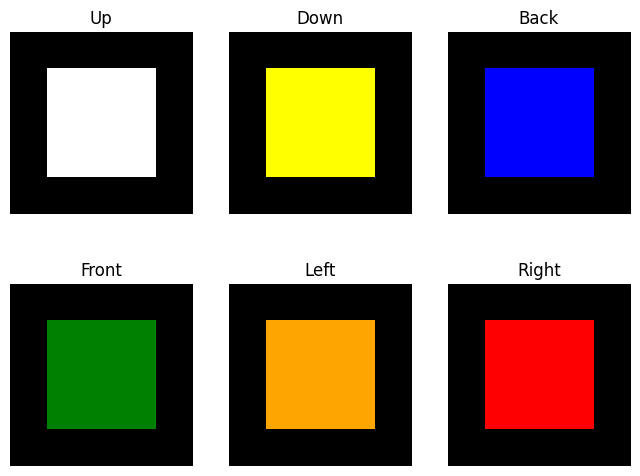

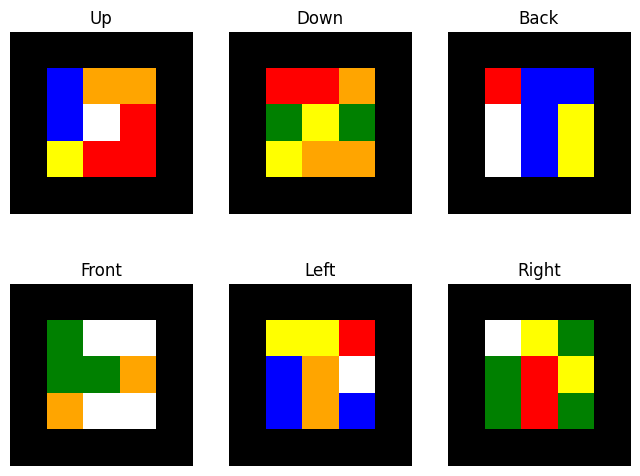

solved False


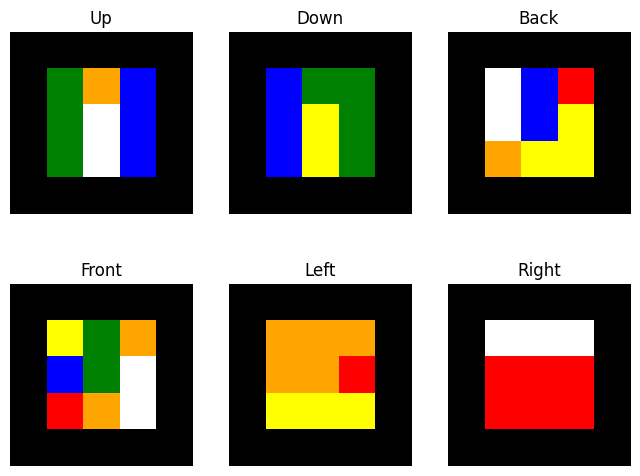

In [10]:
# Initialize and display the cube
cube = init_cube()
display_cube(cube)

num_moves = np.random.randint(1, MAX_MOVES)
moves = random.choices(move_types, k=num_moves)
scrambled_cube = apply_moves(cube, moves)
display_cube(scrambled_cube)
cube, solved = net.solve(scrambled_cube.unsqueeze(0))
print("solved", solved)
display_cube(cube)

# Calculate evaluation accuracy another way

In [11]:
total = 1000
correct = 0
for i in range(total):
    cube = init_cube()
    num_moves = np.random.randint(1, MAX_MOVES)
    moves = random.choices(move_types, k=num_moves)
    scrambled_cube = apply_moves(cube, moves)
    cube, solved = net.solve(scrambled_cube.unsqueeze(0))
    correct += solved

acc = correct * 100 / total
print(f"accuracy {acc:.2f}%")

accuracy 78.00%
